In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score,
    roc_curve, auc,
    precision_recall_curve,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt


In [2]:
import pandas as pd

df = pd.read_csv('/content/invoices_enriched_final.csv')
display(df.head())

,first_name,last_name,email,product_id,qty,amount,invoice_date,address,city,stock_code,job,unit_price,avg_price,cost_price,list_price,discount_pct,margin_pct,salesperson,invoice_delay
0,Carmen Nixon,Todd Anderson,marvinjackson@example.com,133,9,14.57,10/09/1982,283 Wendy Common,West Alexander,36239634,Logistics and distribution manager,1.62,17.16,12.87,21.45,92.45,-87.42,Salesperson_07,0
1,Mrs. Heather Miller,Julia Moore,jeffrey84@example.net,155,5,65.48,03/10/2012,13567 Patricia Circles Apt. 751,Andreamouth,2820163,Osteopath,13.10,15.41,11.55,19.26,31.99,13.34,Salesperson_20,7
2,Crystal May,Philip Moody,ugoodman@example.com,151,9,24.66,23/03/1976,6389 Debbie Island Suite 470,Coxbury,27006726,Economist,2.74,13.51,10.13,16.89,83.77,-72.96,Salesperson_15,4
3,Bobby Weber,Mark Scott,ssanchez@example.com,143,4,21.34,17/08/1986,6362 Ashley Plaza Apt. 994,Ninaland,83036521,Sports administrator,5.34,15.28,11.46,19.10,72.07,-53.44,Salesperson_11,2
4,Kristen Welch,David David,cynthia66@example.net,168,2,83.90,11/06/1996,463 Steven Cliffs Suite 757,Isaiahview,80142652,Chief Marketing Officer,41.95,15.87,11.90,19.84,111.49,252.48,Salesperson_08,0


In [3]:
# ---- Clean & engineer features (same logic as pipeline) ----

# Drop irrelevant columns
for col in ["first_name", "last_name", "email", "address", "job"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# Parse date
if "invoice_date" in df.columns:
    df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")

numeric_cols = [
    "product_id", "qty", "amount",
    "stock_code",
    "unit_price", "avg_price", "cost_price", "list_price",
    "discount_pct", "margin_pct",
    "invoice_delay"
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

if "list_price" in df.columns:
    df["list_price"] = df["list_price"].replace(0, np.nan)

for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# price_gap & price_gap_pct
if {"unit_price", "avg_price"} <= set(df.columns):
    df["price_gap"] = df["unit_price"] - df["avg_price"]
    df["price_gap_pct"] = np.where(
        df["avg_price"] != 0,
        (df["unit_price"] - df["avg_price"]) / df["avg_price"],
        0.0
    )
else:
    df["price_gap"] = 0.0
    df["price_gap_pct"] = 0.0

# expected_margin & margin_gap
if {"avg_price", "cost_price"} <= set(df.columns):
    df["expected_margin"] = np.where(
        df["avg_price"] != 0,
        (df["avg_price"] - df["cost_price"]) / df["avg_price"],
        0.0
    )
else:
    df["expected_margin"] = 0.0

if "margin_pct" in df.columns:
    df["margin_gap"] = df["expected_margin"] - df["margin_pct"]
else:
    df["margin_gap"] = 0.0

for col in ["price_gap", "price_gap_pct", "expected_margin", "margin_gap"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(0.0)

# ---- Business rules / labels (same as pipeline) ----
if "discount_pct" not in df.columns:
    df["discount_pct"] = 0.0
if "price_gap_pct" not in df.columns:
    df["price_gap_pct"] = 0.0
if "margin_gap" not in df.columns:
    df["margin_gap"] = 0.0
if "invoice_delay" not in df.columns:
    df["invoice_delay"] = 0

df["rule_high_discount"] = (df["discount_pct"] > 0.25).astype(int)
df["rule_underpricing"] = (df["price_gap_pct"] < -0.20).astype(int)
df["rule_margin_collapse"] = (df["margin_gap"] > 0.20).astype(int)
df["rule_high_delay"] = (df["invoice_delay"] > 30).astype(int)

df["rule_based_leak"] = (
    df["rule_high_discount"] |
    df["rule_underpricing"] |
    df["rule_margin_collapse"] |
    df["rule_high_delay"]
).astype(int)

if "revenue_leak" not in df.columns:
    df["revenue_leak"] = df["rule_based_leak"]

In [4]:
numeric_features = [
    "qty", "amount",
    "unit_price", "avg_price", "cost_price", "list_price",
    "discount_pct", "margin_pct",
    "invoice_delay",
    "price_gap", "price_gap_pct",
    "expected_margin", "margin_gap"
]
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = [
    "product_id", "city",
    "stock_code",
    "salesperson"
]
categorical_features = [c for c in categorical_features if c in df.columns]

feature_cols = numeric_features + categorical_features

X = df[feature_cols].copy()
y = df["revenue_leak"].astype(int)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [5]:
from sklearn.model_selection import train_test_split

# Shared split for fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight="balanced",
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ),
    "GradientBoostingClassifier": GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ),
}

results = {}
fitted_pipes = {}
y_test_pred = {}
y_test_proba = {}


In [6]:
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", model)
    ])

    # Cross-validation F1
    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring="f1")
    cv_mean = float(cv_scores.mean())
    cv_std = float(cv_scores.std())

    # Fit on train
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Probabilities (for ROC/PR)
    if hasattr(pipe.named_steps["clf"], "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:
        # fallback: decision_function if no predict_proba
        if hasattr(pipe.named_steps["clf"], "decision_function"):
            scores = pipe.decision_function(X_test)
            # scale scores [0,1] roughly (optional)
            y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        else:
            y_prob = y_pred.astype(float)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "cv_f1_mean": cv_mean,
        "cv_f1_std": cv_std,
        "precision_test": float(prec),
        "recall_test": float(rec),
        "f1_test": float(f1),
        "classification_report": report,
        "confusion_matrix": cm
    }

    fitted_pipes[name] = pipe
    y_test_pred[name] = y_pred
    y_test_proba[name] = y_prob

results


{'RandomForest': {'cv_f1_mean': 0.9985937190769999,
  'cv_f1_std': 0.0016418117091317778,
  'precision_test': 0.9984992496248124,
  'recall_test': 1.0,
  'f1_test': 0.9992490613266584,
  'classification_report': {'0': {'precision': 1.0,
    'recall': 0.25,
    'f1-score': 0.4,
    'support': 4.0},
   '1': {'precision': 0.9984992496248124,
    'recall': 1.0,
    'f1-score': 0.9992490613266584,
    'support': 1996.0},
   'accuracy': 0.9985,
   'macro avg': {'precision': 0.9992496248124062,
    'recall': 0.625,
    'f1-score': 0.6996245306633292,
    'support': 2000.0},
   'weighted avg': {'precision': 0.9985022511255628,
    'recall': 0.9985,
    'f1-score': 0.998050563204005,
    'support': 2000.0}},
  'confusion_matrix': array([[   1,    3],
         [   0, 1996]])},
 'LogisticRegression': {'cv_f1_mean': 0.9987980965932103,
  'cv_f1_std': 0.00024585008512100203,
  'precision_test': 0.9984954864593781,
  'recall_test': 0.9974949899799599,
  'f1_test': 0.9979949874686717,
  'classificati

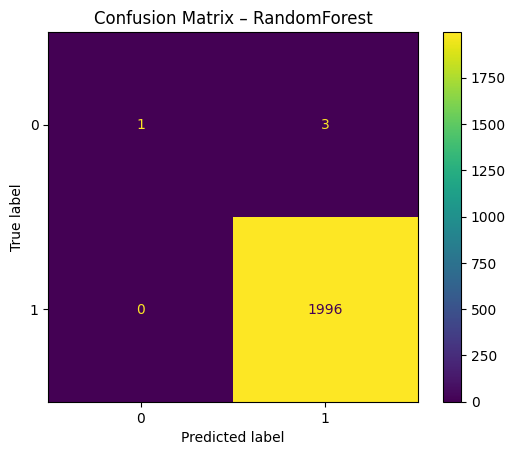

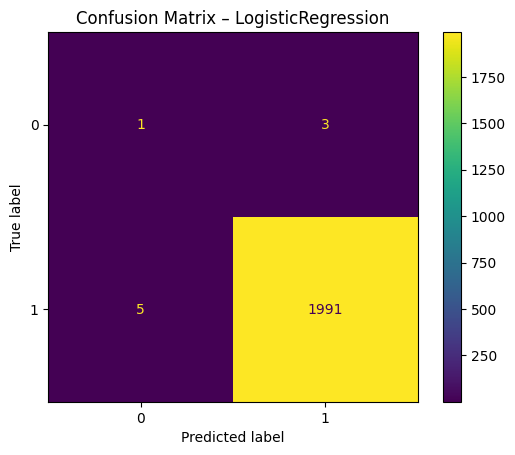

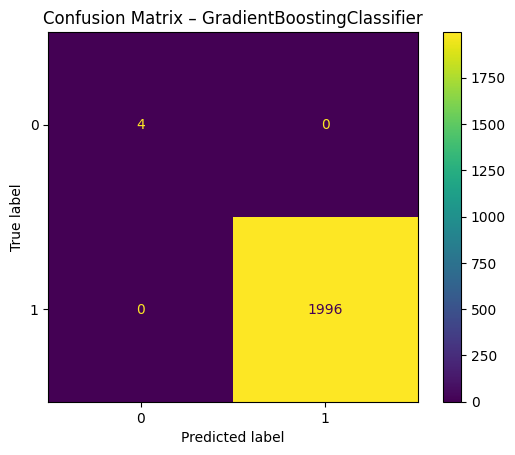

In [7]:
for name in models.keys():
    cm = results[name]["confusion_matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax)
    ax.set_title(f"Confusion Matrix – {name}")
    plt.show()


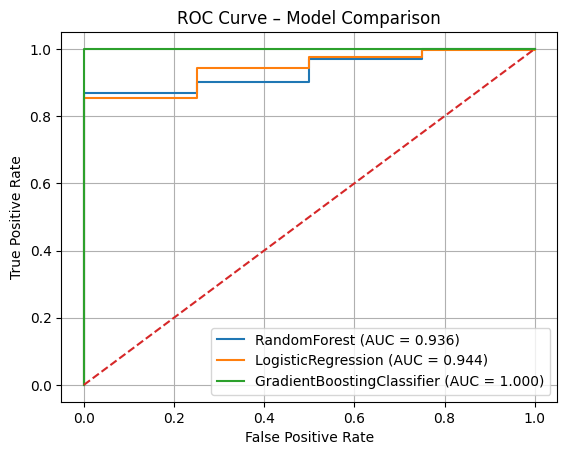

In [8]:
plt.figure()
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Model Comparison")
plt.legend()
plt.grid(True)
plt.show()


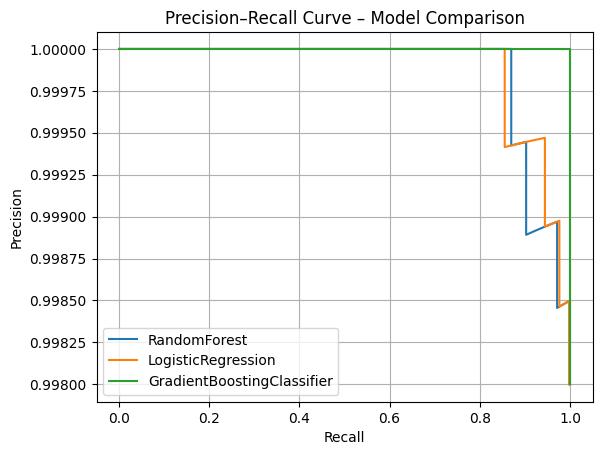

In [9]:
plt.figure()
for name in models.keys():
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba[name])
    plt.plot(recall, precision, label=f"{name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Model Comparison")
plt.legend()
plt.grid(True)
plt.show()


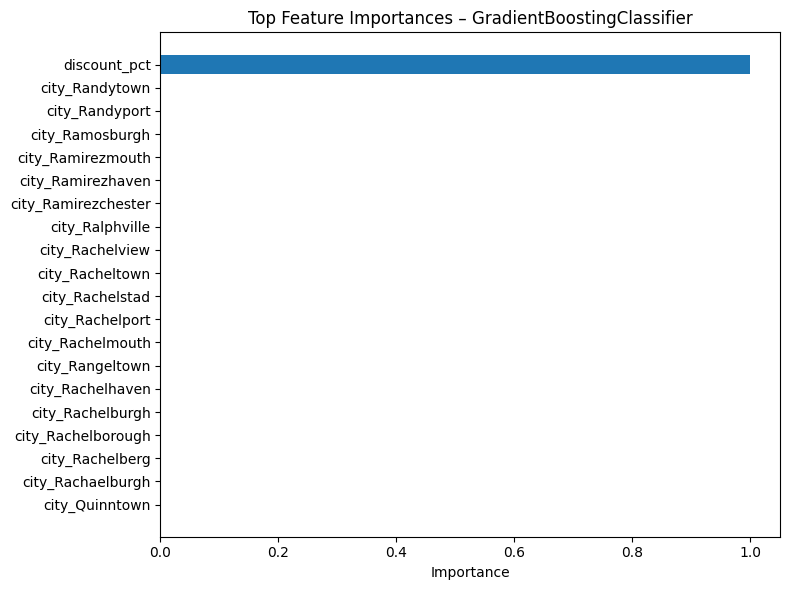

In [10]:
best_name = "GradientBoostingClassifier"
best_pipe = fitted_pipes[best_name]

# Get feature names from ColumnTransformer
feature_names_num = numeric_features
ohe = best_pipe.named_steps["preprocess"].named_transformers_["cat"]
feature_names_cat = ohe.get_feature_names_out(categorical_features).tolist()
all_feature_names = feature_names_num + feature_names_cat

clf = best_pipe.named_steps["clf"]
importances = clf.feature_importances_

# Sort by importance
idx = np.argsort(importances)[::-1]
top_n = 20  # show top 20
top_idx = idx[:top_n]

plt.figure(figsize=(8, 6))
plt.barh(range(len(top_idx)), importances[top_idx][::-1])
plt.yticks(range(len(top_idx)), [all_feature_names[i] for i in top_idx][::-1])
plt.xlabel("Importance")
plt.title("Top Feature Importances – GradientBoostingClassifier")
plt.tight_layout()
plt.show()


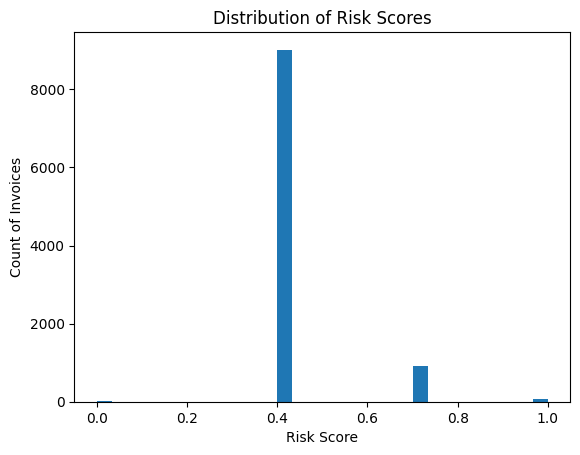

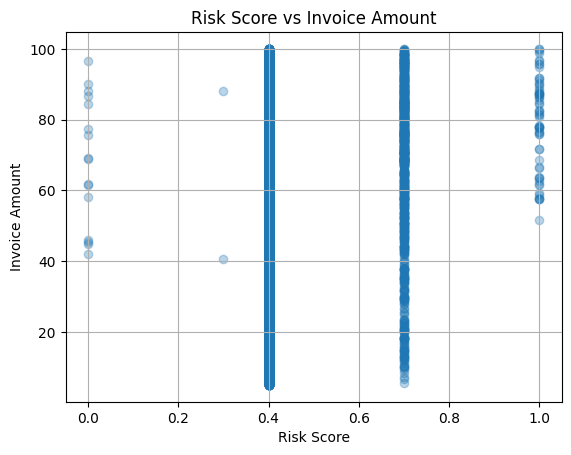

In [11]:
# Change this path if your pipeline saved differently
df_enriched = pd.read_csv("/content/invoices_enriched_output.csv")

# Risk score histogram
plt.figure()
df_enriched["risk_score"].hist(bins=30)
plt.xlabel("Risk Score")
plt.ylabel("Count of Invoices")
plt.title("Distribution of Risk Scores")
plt.grid(False)
plt.show()

# Risk score vs amount (if amount exists)
if "amount" in df_enriched.columns:
    plt.figure()
    plt.scatter(df_enriched["risk_score"], df_enriched["amount"], alpha=0.3)
    plt.xlabel("Risk Score")
    plt.ylabel("Invoice Amount")
    plt.title("Risk Score vs Invoice Amount")
    plt.grid(True)
    plt.show()


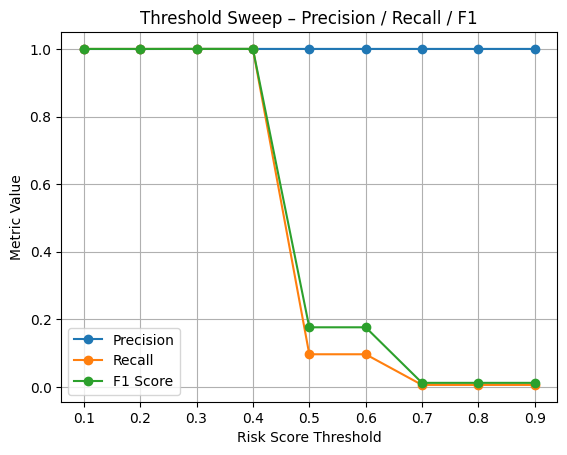

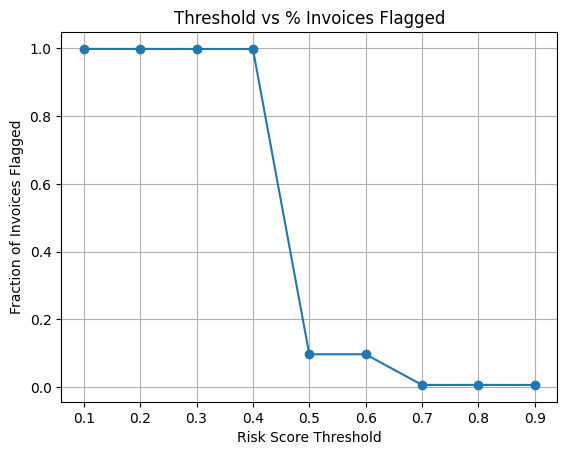

In [12]:
# Recompute sweep from enriched data (if threshold_sweep not reused directly)
thresholds = np.linspace(0.1, 0.9, 9)
precisions, recalls, f1s, flagged = [], [], [], []

for t in thresholds:
    preds = (df_enriched["risk_score"] >= t).astype(int)
    p = precision_score(df_enriched["revenue_leak"], preds, zero_division=0)
    r = recall_score(df_enriched["revenue_leak"], preds, zero_division=0)
    f = f1_score(df_enriched["revenue_leak"], preds, zero_division=0)
    frac = preds.mean()
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)
    flagged.append(frac)

plt.figure()
plt.plot(thresholds, precisions, marker="o", label="Precision")
plt.plot(thresholds, recalls, marker="o", label="Recall")
plt.plot(thresholds, f1s, marker="o", label="F1 Score")
plt.xlabel("Risk Score Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Sweep – Precision / Recall / F1")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(thresholds, flagged, marker="o")
plt.xlabel("Risk Score Threshold")
plt.ylabel("Fraction of Invoices Flagged")
plt.title("Threshold vs % Invoices Flagged")
plt.grid(True)
plt.show()


In [19]:
# Reload raw dataset for visualization
df_eval = pd.read_csv("invoices_enriched_final.csv")

# Drop irrelevant fields
for col in ["first_name", "last_name", "email", "address", "job"]:
    if col in df_eval.columns:
        df_eval.drop(columns=col, inplace=True)

# Convert date
if "invoice_date" in df_eval.columns:
    df_eval["invoice_date"] = pd.to_datetime(df_eval["invoice_date"], errors="coerce")

# Numeric conversion
numeric_cols = [
    "product_id", "qty", "amount",
    "stock_code",
    "unit_price", "avg_price", "cost_price", "list_price",
    "discount_pct", "margin_pct",
    "invoice_delay"
]

for col in numeric_cols:
    if col in df_eval.columns:
        df_eval[col] = pd.to_numeric(df_eval[col], errors="coerce")

# Replace bad list_price
if "list_price" in df_eval.columns:
    df_eval["list_price"] = df_eval["list_price"].replace(0, np.nan)

# Fill numeric nulls
for col in numeric_cols:
    if col in df_eval.columns:
        df_eval[col] = df_eval[col].fillna(df_eval[col].median())

# Features: price_gap, price_gap_pct
df_eval["price_gap"] = df_eval["unit_price"] - df_eval["avg_price"]
df_eval["price_gap_pct"] = np.where(
    df_eval["avg_price"] != 0,
    (df_eval["unit_price"] - df_eval["avg_price"]) / df_eval["avg_price"],
    0.0
)

# Features: expected_margin, margin_gap
df_eval["expected_margin"] = np.where(
    df_eval["avg_price"] != 0,
    (df_eval["avg_price"] - df_eval["cost_price"]) / df_eval["avg_price"],
    0.0
)

df_eval["margin_gap"] = df_eval["expected_margin"] - df_eval["margin_pct"]

# Clean engineered fields
for col in ["price_gap", "price_gap_pct", "expected_margin", "margin_gap"]:
    df_eval[col] = df_eval[col].replace([np.inf, -np.inf], np.nan).fillna(0.0)


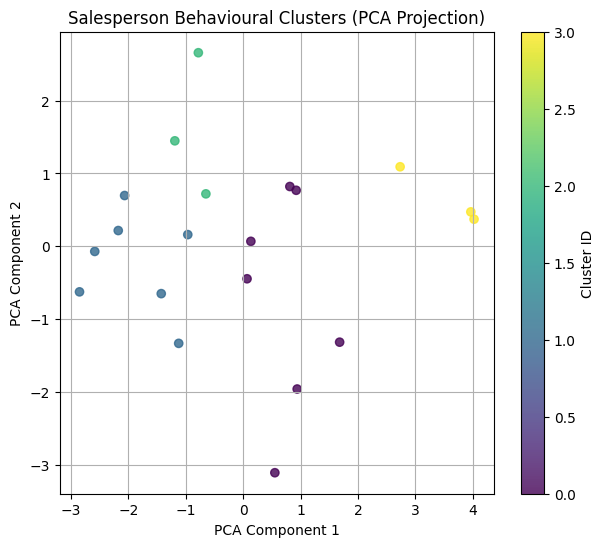

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Use enriched data for clusters (has sales_cluster)
df_clusters = df_enriched.copy()

# Filter rows with valid salesperson & cluster
df_clusters = df_clusters.dropna(subset=["salesperson", "sales_cluster"])

# Aggregate salesperson behaviour (same logic as clustering)
agg = df_clusters.groupby("salesperson").agg({
    "discount_pct": "mean",
    "margin_pct": "mean",
    "price_gap_pct": "mean",
    "invoice_delay": "mean",
    "qty": "mean",
    "unit_price": "mean",
    "amount": "mean"
}).fillna(0)

features_for_cluster = [
    c for c in ["discount_pct", "margin_pct", "price_gap_pct",
                "invoice_delay", "qty", "unit_price", "amount"]
    if c in agg.columns
]

X_beh = agg[features_for_cluster].values

# Standardize and apply PCA
scaler_beh = StandardScaler()
X_beh_scaled = scaler_beh.fit_transform(X_beh)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_beh_scaled)

# Map salesperson → cluster id from df_enriched
salesperson_to_cluster = (df_clusters
                          .groupby("salesperson")["sales_cluster"]
                          .first()
                          .to_dict())

clusters = [salesperson_to_cluster[sp] for sp in agg.index]

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=clusters, alpha=0.8)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Salesperson Behavioural Clusters (PCA Projection)")
plt.colorbar(scatter, label="Cluster ID")
plt.grid(True)
plt.show()


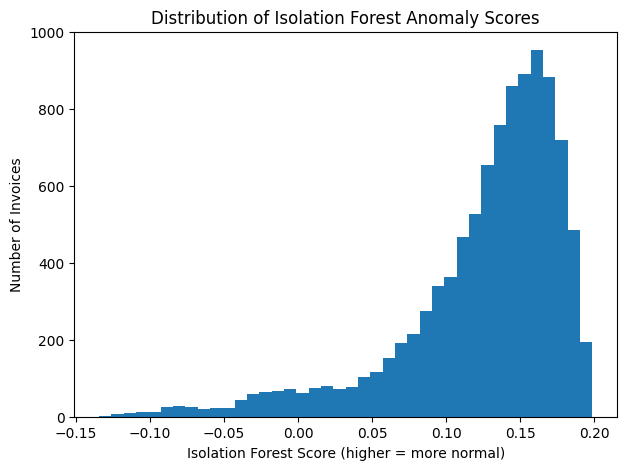

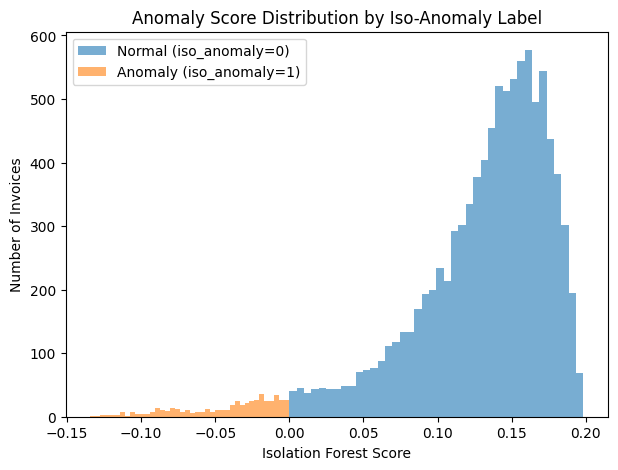

In [15]:
from sklearn.ensemble import IsolationForest

# Use engineered eval dataset (df_eval)
anomaly_features = [
    "qty", "amount",
    "unit_price", "avg_price", "cost_price", "list_price",
    "discount_pct", "margin_pct",
    "invoice_delay",
    "price_gap", "price_gap_pct",
    "expected_margin", "margin_gap"
]
anomaly_features = [c for c in anomaly_features if c in df_eval.columns]

X_anom = df_eval[anomaly_features].fillna(0).values

scaler_anom = StandardScaler()
X_anom_scaled = scaler_anom.fit_transform(X_anom)

iso_viz = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)
iso_viz.fit(X_anom_scaled)

# decision_function gives anomaly scores (higher = more normal, lower = more anomalous)
scores = iso_viz.decision_function(X_anom_scaled)

plt.figure(figsize=(7, 5))
plt.hist(scores, bins=40)
plt.xlabel("Isolation Forest Score (higher = more normal)")
plt.ylabel("Number of Invoices")
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.grid(False)
plt.show()

# Optional: compare score distributions for iso_anomaly=0 vs 1 (from enriched df)
if "iso_anomaly" in df_enriched.columns:
    df_scores = df_enriched.copy()
    # align lengths in case of minor mismatch
    n = min(len(df_scores), len(scores))
    df_scores = df_scores.iloc[:n, :].copy()
    df_scores["iso_score"] = scores[:n]

    plt.figure(figsize=(7, 5))
    df_scores[df_scores["iso_anomaly"] == 0]["iso_score"].hist(
        bins=40, alpha=0.6, label="Normal (iso_anomaly=0)"
    )
    df_scores[df_scores["iso_anomaly"] == 1]["iso_score"].hist(
        bins=40, alpha=0.6, label="Anomaly (iso_anomaly=1)"
    )
    plt.xlabel("Isolation Forest Score")
    plt.ylabel("Number of Invoices")
    plt.title("Anomaly Score Distribution by Iso-Anomaly Label")
    plt.legend()
    plt.grid(False)
    plt.show()


Missing columns for price deviation plot: []


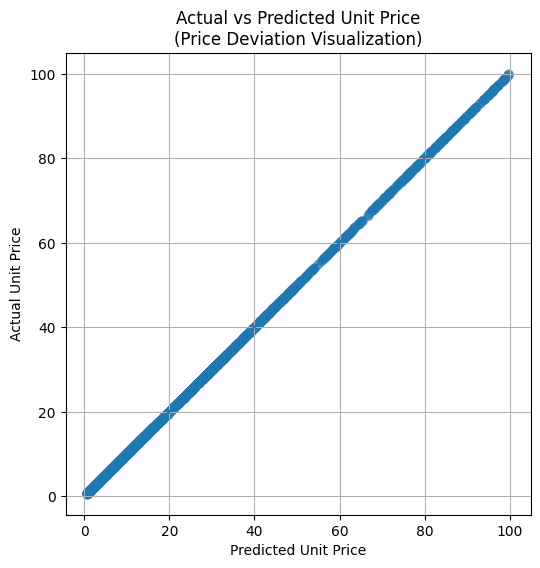

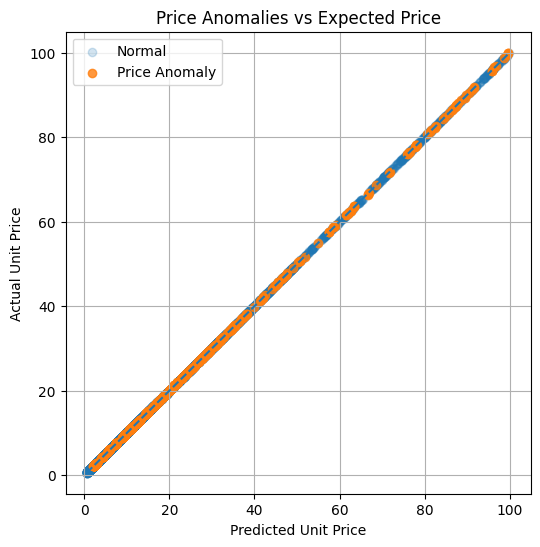

In [23]:
# Ensure required columns exist
cols_needed = ["unit_price", "predicted_price"]
missing = [c for c in cols_needed if c not in df_enriched.columns]
print("Missing columns for price deviation plot:", missing)

if not missing:
    plt.figure(figsize=(6, 6))
    plt.scatter(df_enriched["predicted_price"],
                df_enriched["unit_price"],
                alpha=0.3)
    max_val = max(df_enriched["predicted_price"].max(),
                  df_enriched["unit_price"].max())
    min_val = min(df_enriched["predicted_price"].min(),
                  df_enriched["unit_price"].min())
    plt.plot([min_val, max_val], [min_val, max_val],
             linestyle="--")  # y=x reference line

    plt.xlabel("Predicted Unit Price")
    plt.ylabel("Actual Unit Price")
    plt.title("Actual vs Predicted Unit Price\n(Price Deviation Visualization)")
    plt.grid(True)
    plt.show()

    # Optional: highlight anomalies only
    if "price_anomaly" in df_enriched.columns:
        plt.figure(figsize=(6, 6))
        normal = df_enriched[df_enriched["price_anomaly"] == 0]
        anom = df_enriched[df_enriched["price_anomaly"] == 1]

        plt.scatter(normal["predicted_price"], normal["unit_price"],
                    alpha=0.2, label="Normal")
        plt.scatter(anom["predicted_price"], anom["unit_price"],
                    alpha=0.8, label="Price Anomaly")

        plt.plot([min_val, max_val], [min_val, max_val],
                 linestyle="--")

        plt.xlabel("Predicted Unit Price")
        plt.ylabel("Actual Unit Price")
        plt.title("Price Anomalies vs Expected Price")
        plt.legend()
        plt.grid(True)
        plt.show()


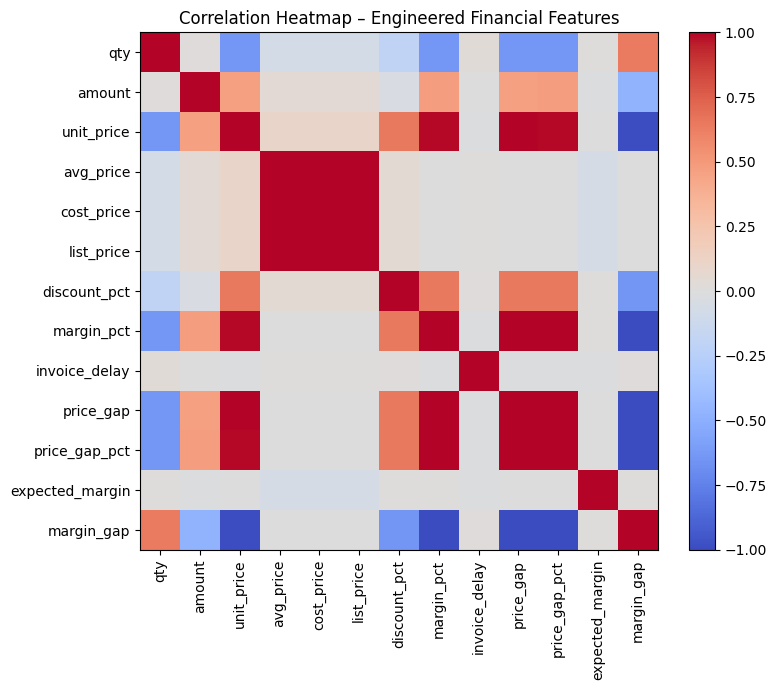

In [24]:
# Select key engineered numeric features
corr_features = [
    "qty", "amount",
    "unit_price", "avg_price", "cost_price", "list_price",
    "discount_pct", "margin_pct",
    "invoice_delay",
    "price_gap", "price_gap_pct",
    "expected_margin", "margin_gap"
]
corr_features = [c for c in corr_features if c in df_eval.columns]

corr_matrix = df_eval[corr_features].corr()

plt.figure(figsize=(9, 7))
im = plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_features)), corr_features, rotation=90)
plt.yticks(range(len(corr_features)), corr_features)
plt.title("Correlation Heatmap – Engineered Financial Features")
plt.tight_layout()
plt.show()
